In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Get the data
data = pd.read_pickle("../Data/final_data1.df")
# data = pd.read_pickle("../Data/old_data.df")
data.replace("New Jersey Nets", "Brooklyn Nets", inplace=True)
data.replace("New Orleans Hornets", "New Orleans Pelicans", inplace=True)
data.replace("Charlotte Bobcats", "Charlotte Hornets", inplace=True)
data.replace("LA Clippers", "Los Angeles Clippers", inplace=True)
data.replace("NJN", "BRK", inplace=True)
data.replace("NOH", "NOP", inplace=True)
data.replace("CHA", "CHO", inplace=True)
data.replace("CHH", "CHO", inplace=True)
data.replace("VAN", "MEM", inplace=True)
data.replace("SEA", "OKC", inplace=True)
data.replace("NOK", "NOP", inplace=True)

data.rename(columns={"Name":"Player", "Guard":"G", "Center":"C", "Forward":"F", 
                     "awardCount":"awards", "mock1":"m1", "mock2":"m2", "mock3":"m3", "mock4":"m4",
                     "mock5":"m5", "mock6":"m6", }, inplace=True)
data = data.drop_duplicates(subset=["Player"])
data["WM"] = [(data["EWA"].iloc[i]+data["WP"].iloc[i] + data["WS"].iloc[i])/3. for i in range(len(data))]
data.dropna(subset=["WM"], inplace=True)
data.reset_index(drop=True, inplace=True)

x_cols = ['gamesPlayed', 'minutes', 'FT%', '3P%', 'SOS',
       'PER', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'USG%',
       'OWS', 'DWS', 'FTA', 'FGA', 'MP', '3PA', 'PTS', 'PF', 'MP_per_PF', 'PPG', 'PPM',
       'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA', "AST_per_TOV", 'ORtg', 'DRtg', # "WING_DIFF",
       'awards', # 'age', 
       'RSCI', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'SHUTTLE_RUN',
       'THREE_QUARTER_SPRINT', 'STANDING_VERTICAL', 'MAX_VERTICAL',
       'BENCH_PRESS', 'BODY_FAT', 'HAND_LENGTH', 'HAND_WIDTH', "didCombine", 
       'HEIGHT_W_SHOES', 'REACH', 'WEIGHT', 'WINGSPAN', 'C', 'F', 'G']
X = data[x_cols]

Y = data["WM"]
print(X.isnull().sum().any())
print(Y.isnull().sum().any())

False
False


In [2]:
batch_size = 20
epochs = 20
N = len(x_cols)
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(N, input_dim=N, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

if "WM_pred" in data.columns:
    data.drop(["WM_pred"], axis=1, inplace=True)

# Set up oversampling
osX, osY = X.copy(), Y.copy()
highValue = 3
highX, highY = osX[osY > highValue], osY[osY > highValue]
lowValue = 0.1
lowX, lowY = osX[osY > lowValue], osY[osY > lowValue]
remainingVals = len(X) - len(highX) - len(lowX)

for i in range(len(highX)*2):
    addRow = np.random.randint(len(highX))
    osX = osX.append(highX.iloc[addRow])
    osY = osY.append(pd.Series(highY.iloc[addRow]))
    
for i in range(len(lowX)*2):
    addRow = np.random.randint(len(lowX))
    osX = osX.append(lowX.iloc[addRow])
    osY = osY.append(pd.Series(lowY.iloc[addRow]))    

osX.reset_index(inplace=True, drop=True)
osY.reset_index(inplace=True, drop=True)
X.reset_index(inplace=True, drop=True)
loo = LeaveOneOut()
preds = pd.DataFrame(index=data.index, columns=["WM_pred"])
for _, test_index in loo.split(X):
    # Split the data according to the oversampling
    X_test, Y_test = X.loc[test_index], Y.loc[test_index]
    X_train = osX.drop([test_index[0]], axis=0, inplace=False)
    Y_train = osY.drop([test_index[0]], axis=0, inplace=False)
    
    X_train = X_train[X_train.index!=X_test.index.values[0]]
    Y_train = Y_train[X_train.index!=X_test.index.values[0]]

    model = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
    model = Pipeline([#('scaler', StandardScaler()), 
                      ('model', model)])
    model.fit(np.asarray(X_train).astype("float32"), Y_train)
    preds["WM_pred"].iloc[test_index] = model.predict(np.asarray(X_test).astype("float32"))
    print("{}/{} complete!".format(test_index[0]+1, len(X)))
    
data = pd.concat([data, preds], axis=1, sort=False)
datatypes = {"WM_pred":float}
data = data.astype(datatypes)
# NEED TO FIX THIS CURRENTLY TRAINING COULD BE IN TESTING

W0301 21:41:20.377251 4591091200 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


1/660 complete!
2/660 complete!
3/660 complete!
4/660 complete!
5/660 complete!
6/660 complete!
7/660 complete!
8/660 complete!
9/660 complete!
10/660 complete!
11/660 complete!
12/660 complete!
13/660 complete!
14/660 complete!
15/660 complete!
16/660 complete!
17/660 complete!
18/660 complete!
19/660 complete!
20/660 complete!
21/660 complete!
22/660 complete!
23/660 complete!
24/660 complete!
25/660 complete!
26/660 complete!
27/660 complete!
28/660 complete!
29/660 complete!
30/660 complete!
31/660 complete!
32/660 complete!
33/660 complete!
34/660 complete!
35/660 complete!
36/660 complete!
37/660 complete!
38/660 complete!
39/660 complete!
40/660 complete!
41/660 complete!
42/660 complete!
43/660 complete!
44/660 complete!
45/660 complete!
46/660 complete!
47/660 complete!
48/660 complete!
49/660 complete!
50/660 complete!
51/660 complete!
52/660 complete!
53/660 complete!
54/660 complete!
55/660 complete!
56/660 complete!
57/660 complete!
58/660 complete!
59/660 complete!
60/660

463/660 complete!
464/660 complete!
465/660 complete!
466/660 complete!
467/660 complete!
468/660 complete!
469/660 complete!
470/660 complete!
471/660 complete!
472/660 complete!
473/660 complete!
474/660 complete!
475/660 complete!
476/660 complete!
477/660 complete!
478/660 complete!
479/660 complete!
480/660 complete!
481/660 complete!
482/660 complete!
483/660 complete!
484/660 complete!
485/660 complete!
486/660 complete!
487/660 complete!
488/660 complete!
489/660 complete!
490/660 complete!
491/660 complete!
492/660 complete!
493/660 complete!
494/660 complete!
495/660 complete!
496/660 complete!
497/660 complete!
498/660 complete!
499/660 complete!
500/660 complete!
501/660 complete!
502/660 complete!
503/660 complete!
504/660 complete!
505/660 complete!
506/660 complete!
507/660 complete!
508/660 complete!
509/660 complete!
510/660 complete!
511/660 complete!
512/660 complete!
513/660 complete!
514/660 complete!
515/660 complete!
516/660 complete!
517/660 complete!
518/660 co

WM MSE: 2.6007441372843303


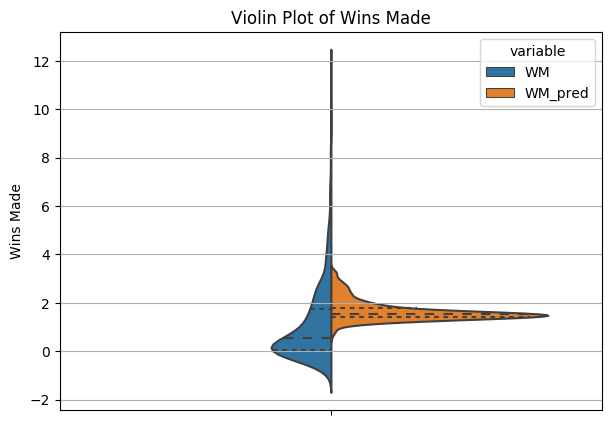

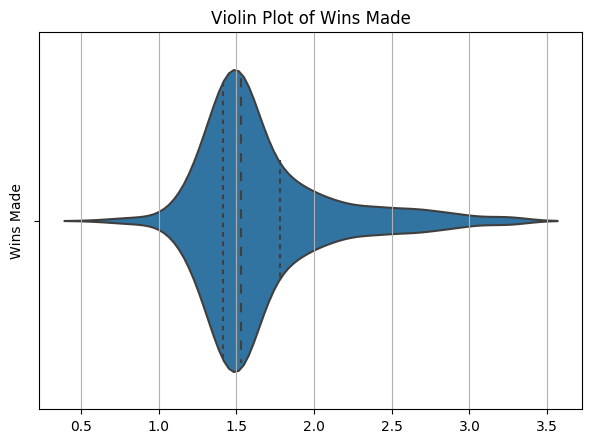

In [3]:
# Calculate some of the errors
from sklearn.metrics import mean_squared_error
print("WM MSE: {}".format(mean_squared_error(data.loc[data["WM"].isnull()==False]["WM"], preds.loc[data["WM"].isnull()==False]["WM_pred"], squared=True)))

# Some plotting of these
import seaborn as sns

plt.figure(figsize=(7,5), dpi=100)
plt.title("Violin Plot of Wins Made")
plt.grid()
plotData = data[["WM", "WM_pred"]].melt().assign(x="")
sns.violinplot(data=plotData, x="x", y="value", hue="variable", inner="quartile", split=True)
plt.ylabel("Wins Made")
plt.xlabel("")
plt.show()

plt.figure(figsize=(7,5), dpi=100)
plt.title("Violin Plot of Wins Made")
plt.grid()
sns.violinplot(data=data, x="WM_pred", inner="quartile", split=True)
plt.ylabel("Wins Made")
plt.xlabel("")
plt.show()


In [4]:
data.isnull().sum()

Pk         0
Tm         0
Player     0
Year       0
HEIGHT     0
          ..
C          0
F          0
G          0
WM         0
WM_pred    0
Length: 71, dtype: int64

In [5]:
# Create a mock draft to evaluate how many wins are gained
data.rename(columns={"Year":"draftYear", "Tm":"NBAteam", "Pk":"overallPick", "Player":"Name"}, inplace=True)
# data = data.astype({"draftYear":int, "overallPick":int})
selectData = data# [data.did3years==True] # SNEAKY HERE - WATCH OUT
simData = pd.DataFrame(columns=["team", "oldPick", "newPick", "year"])
ALL_TEAMS = data["NBAteam"].unique()
for year in np.unique(data["draftYear"]):
    if year > 2015:
        continue
    yearData = selectData.loc[data["draftYear"]==year]
    yearData.sort_values(by=["overallPick"], inplace=True)
    picks, teams = yearData["overallPick"].to_numpy(), yearData["NBAteam"].to_numpy()
    picks, teams = picks[~pd.isnull(picks)], teams[~pd.isnull(teams)]
    
    for myTeam in ALL_TEAMS:
        print("YEAR: {}, TEAM: {}".format(year, myTeam))
        oldPicks = yearData.loc[yearData["NBAteam"]==myTeam]["Name"].to_numpy()
        myPicks = yearData.loc[yearData["NBAteam"]==myTeam]['overallPick'].to_numpy()
        alreadyPicked = []
        myActualPicks = []
        
        # Figure out what the new picks will be
        for pick in picks:
            avalPicks = yearData[~yearData.Name.isin(alreadyPicked)]
                
            if pick in myPicks:
                # Choose highest remaining target value
                myPick = avalPicks.loc[avalPicks["WM_pred"]==max(avalPicks["WM_pred"])]["Name"].iloc[0]
                alreadyPicked.append(myPick)
                myActualPicks.append(myPick)
            else:
                theirPick = avalPicks.loc[avalPicks['overallPick']==min(avalPicks['overallPick'])]["Name"].iloc[0]
                alreadyPicked.append(theirPick)
        if len(np.unique(myActualPicks))!=len(myActualPicks):
            print("ERROR")
        for i in range(len(myPicks)):
            teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
            teamSeries["year"] = year
            teamSeries["team"] = myTeam
            teamSeries["oldPick"] = oldPicks[i]
            teamSeries["newPick"] = myActualPicks[i]
            teamSeries['overallPick'] = myPicks[i]
            
            simData = simData.append(teamSeries, ignore_index=True)
            

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


YEAR: 2000, TEAM: PHI
YEAR: 2000, TEAM: LAL
YEAR: 2000, TEAM: BOS
YEAR: 2000, TEAM: PHO
YEAR: 2000, TEAM: SAC
YEAR: 2000, TEAM: ORL
YEAR: 2000, TEAM: MIN
YEAR: 2000, TEAM: DAL
YEAR: 2000, TEAM: CHO
YEAR: 2000, TEAM: DET
YEAR: 2000, TEAM: DEN
YEAR: 2000, TEAM: MIA
YEAR: 2000, TEAM: CHI
YEAR: 2000, TEAM: MIL
YEAR: 2000, TEAM: IND
YEAR: 2000, TEAM: ATL
YEAR: 2000, TEAM: POR
YEAR: 2000, TEAM: BRK
YEAR: 2000, TEAM: TOR
YEAR: 2000, TEAM: UTA
YEAR: 2000, TEAM: SAS
YEAR: 2000, TEAM: NOP
YEAR: 2000, TEAM: NYK
YEAR: 2000, TEAM: HOU
YEAR: 2000, TEAM: LAC
YEAR: 2000, TEAM: GSW
YEAR: 2000, TEAM: OKC
YEAR: 2000, TEAM: WAS
YEAR: 2000, TEAM: CLE
YEAR: 2000, TEAM: MEM
YEAR: 2001, TEAM: PHI
YEAR: 2001, TEAM: LAL
YEAR: 2001, TEAM: BOS
YEAR: 2001, TEAM: PHO
YEAR: 2001, TEAM: SAC
YEAR: 2001, TEAM: ORL
YEAR: 2001, TEAM: MIN
YEAR: 2001, TEAM: DAL
YEAR: 2001, TEAM: CHO
YEAR: 2001, TEAM: DET
YEAR: 2001, TEAM: DEN
YEAR: 2001, TEAM: MIA
YEAR: 2001, TEAM: CHI
YEAR: 2001, TEAM: MIL
YEAR: 2001, TEAM: IND
YEAR: 2001

YEAR: 2012, TEAM: IND
YEAR: 2012, TEAM: ATL
YEAR: 2012, TEAM: POR
YEAR: 2012, TEAM: BRK
YEAR: 2012, TEAM: TOR
YEAR: 2012, TEAM: UTA
YEAR: 2012, TEAM: SAS
YEAR: 2012, TEAM: NOP
YEAR: 2012, TEAM: NYK
YEAR: 2012, TEAM: HOU
YEAR: 2012, TEAM: LAC
YEAR: 2012, TEAM: GSW
YEAR: 2012, TEAM: OKC
YEAR: 2012, TEAM: WAS
YEAR: 2012, TEAM: CLE
YEAR: 2012, TEAM: MEM
YEAR: 2013, TEAM: PHI
YEAR: 2013, TEAM: LAL
YEAR: 2013, TEAM: BOS
YEAR: 2013, TEAM: PHO
YEAR: 2013, TEAM: SAC
YEAR: 2013, TEAM: ORL
YEAR: 2013, TEAM: MIN
YEAR: 2013, TEAM: DAL
YEAR: 2013, TEAM: CHO
YEAR: 2013, TEAM: DET
YEAR: 2013, TEAM: DEN
YEAR: 2013, TEAM: MIA
YEAR: 2013, TEAM: CHI
YEAR: 2013, TEAM: MIL
YEAR: 2013, TEAM: IND
YEAR: 2013, TEAM: ATL
YEAR: 2013, TEAM: POR
YEAR: 2013, TEAM: BRK
YEAR: 2013, TEAM: TOR
YEAR: 2013, TEAM: UTA
YEAR: 2013, TEAM: SAS
YEAR: 2013, TEAM: NOP
YEAR: 2013, TEAM: NYK
YEAR: 2013, TEAM: HOU
YEAR: 2013, TEAM: LAC
YEAR: 2013, TEAM: GSW
YEAR: 2013, TEAM: OKC
YEAR: 2013, TEAM: WAS
YEAR: 2013, TEAM: CLE
YEAR: 2013

In [6]:
# Calculate the average added wins !!!!!!!
resultCols = ["team", "oldWins", "newWins", "addedWins", "numPicks"]
resultsData = pd.DataFrame(columns=resultCols)
for team in np.unique(simData["team"]):
    teamData = simData[simData["team"]==team]
    oldWins, newWins = [], []
    for i in range(len(teamData)):
        oldPlayer = teamData["oldPick"].iloc[i]
        newPlayer = teamData["newPick"].iloc[i]
        oW = data[data["Name"]==oldPlayer]["WM"].iloc[0]
        nW = data[data["Name"]==newPlayer]["WM"].iloc[0]
        if pd.isnull(oW) or pd.isnull(nW):
            continue
        oldWins.append(oW)
        newWins.append(nW)

    resultSeries = pd.Series(index=resultCols)
    resultSeries["team"] = team
    resultSeries["oldWins"] = np.mean(oldWins)
    resultSeries["newWins"] = np.mean(newWins)
    resultSeries["addedWins"] = np.mean([newWins[i] - oldWins[i] for i in range(len(newWins))])# np.mean(newWins) - np.mean(oldWins)
    resultSeries["numPicks"] = len(teamData)
    resultsData = resultsData.append(resultSeries, ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


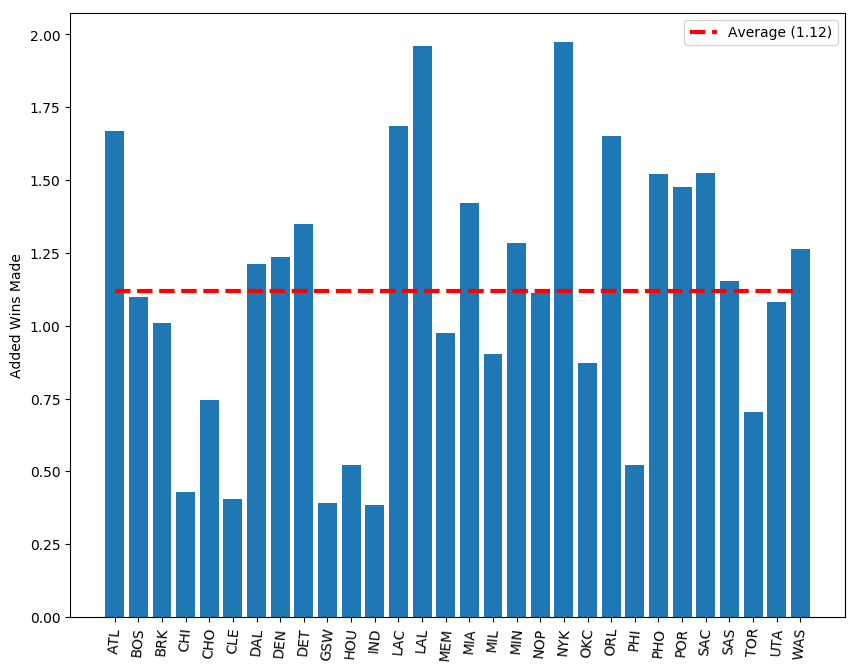

In [7]:
# Create a plot from this!
plt.figure(figsize=(10,8), dpi=100)
labels = resultsData.team.to_numpy()
heights = resultsData.addedWins.to_numpy()
avgHeight = np.mean(heights)

x = range(len(labels))
plt.bar(x, heights)
plt.plot([min(x), max(x)], [avgHeight, avgHeight], "--r", linewidth=3, label="Average ({:.2f})".format(avgHeight))
plt.legend()

plt.ylabel("Added Wins Made")
plt.xticks(x, labels, rotation=85)
plt.show()

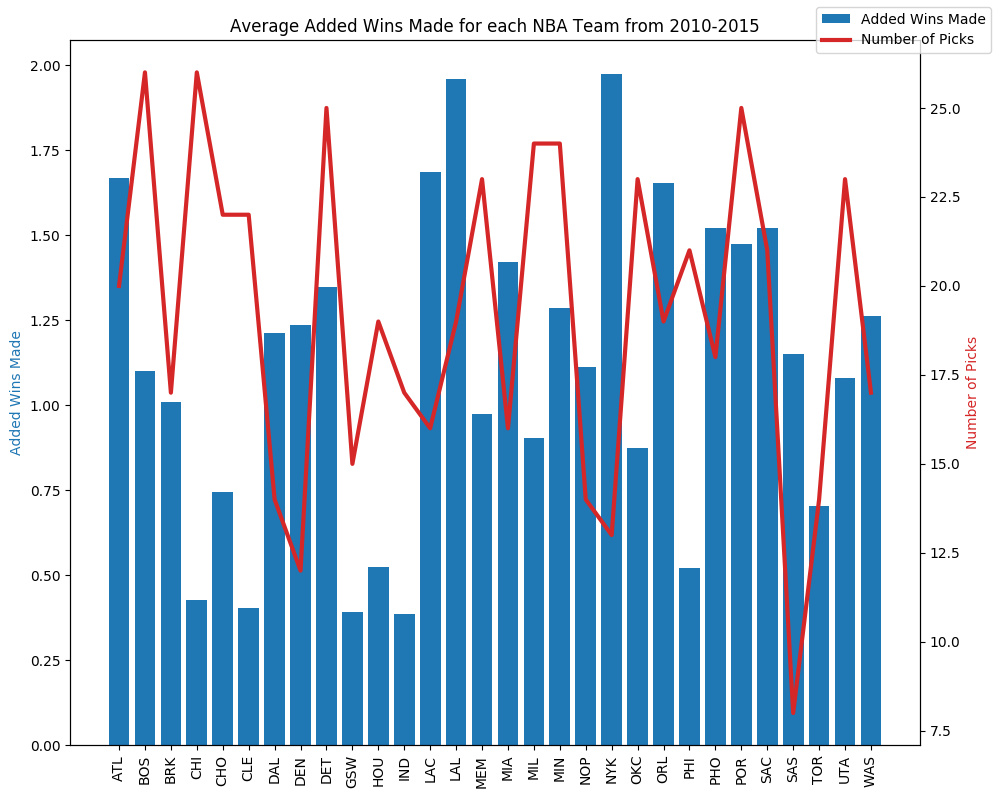

In [8]:
labels = resultsData.team.to_numpy()
x = range(len(labels))
heights = resultsData.addedWins.to_numpy()
avgHeight = np.mean(heights)
freq = resultsData.numPicks.to_numpy()

fig, ax1 = plt.subplots(figsize=(10,8), dpi=100)

color = 'tab:blue'
ax1.set_ylabel("Added Wins Made", color=color)
ax1.bar(x, heights, color=color, label="Added Wins Made")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Number of Picks', color=color)  # we already handled the x-label with ax1
ax2.plot(x, freq, color=color, label="Number of Picks", linewidth=3)
fig.legend()
ax1.set_title("Average Added Wins Made for each NBA Team from 2010-2015")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
# plot the average value
oldWMs = []
newWMs = []
for i in range(len(simData)):
    oldPlayer = simData["oldPick"].iloc[i]
    newPlayer = simData["newPick"].iloc[i]
    
    oldWM = data[data["Name"]==oldPlayer].iloc[0]["WM"]
    newWM = data[data["Name"]==newPlayer].iloc[0]["WM"]
    
    if pd.isnull(oldWM) or pd.isnull(newWM):
        continue
    
    oldWMs.append(oldWM)
    newWMs.append(newWM)

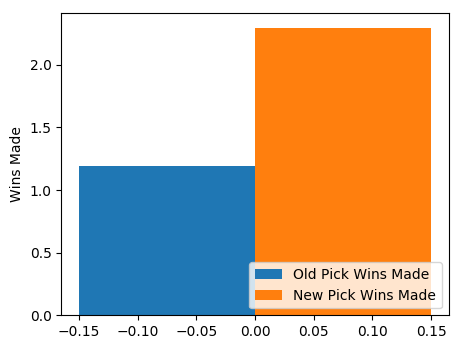

In [10]:
plt.figure(figsize=(5,4), dpi=100)
width = 0.15       # the width of the bars
r1 = width/2.
r2 = -width/2.

plt.bar(r2, [np.mean(oldWMs)], width=width, label="Old Pick Wins Made")
plt.bar(r1, [np.mean(newWMs)], width=width, label="New Pick Wins Made")

plt.ylabel("Wins Made")

plt.legend(loc="lower right")
plt.show()

In [11]:
np.mean(newWMs)/np.mean(oldWMs)

1.9216347012683306

In [12]:
np.sum(Y>2.5)

105

In [13]:
newWMs

[0.2555555555555556,
 0.2555555555555556,
 0.6444444444444445,
 0.2555555555555556,
 1.7,
 1.488888888888889,
 0.2555555555555556,
 0.6444444444444445,
 0.2555555555555556,
 0.6444444444444445,
 0.6444444444444445,
 0.6444444444444445,
 0.6444444444444445,
 0.2555555555555556,
 0.6444444444444445,
 1.488888888888889,
 1.488888888888889,
 0.2555555555555556,
 1.488888888888889,
 0.2555555555555556,
 0.6444444444444445,
 0.3666666666666667,
 0.2555555555555556,
 0.2555555555555556,
 1.488888888888889,
 0.2555555555555556,
 2.622222222222222,
 2.622222222222222,
 2.622222222222222,
 2.622222222222222,
 2.622222222222222,
 -0.41111111111111115,
 0.08333333333333333,
 2.622222222222222,
 2.622222222222222,
 2.622222222222222,
 0.3444444444444444,
 2.622222222222222,
 2.622222222222222,
 -0.41111111111111115,
 2.622222222222222,
 2.622222222222222,
 2.622222222222222,
 -0.41111111111111115,
 2.622222222222222,
 0.3444444444444444,
 2.622222222222222,
 2.622222222222222,
 2.622222222222222,
 